## Keyword Extraction Notebook

In this notebook, we do keyword extraction using transformers' embeddings on [inspec](https://github.com/LIAAD/KeywordExtractor-Datasets/blob/master/datasets/Inspec.zip) dataset. Here, we are not extracting top keywords of each individual document. Instead, we are getting top keywords of all documents in the dataset. Of course, a byproduct of these process is the top keywords of each individual documents. All keywords extracted with these model are present in the document set.

### Definition
We consider a noun phrase a top keyword of given corpus, if it is among the most repeated words in the corpus, and moreover it is in the top most semantically similar keywords to different documents of the corpus.

Semantically similarity is defined to be cosine similarity of two embedding vectors from latent space of a distilled transformer model.

### Note
In this notebook, we restrict our work to uni-grams and bi-grams as words.

### Most Repeated Words
To get the most repeated words, we use Countvectorizer, which counts the number of occurrences of a each word in each document. We sum up the number of occurrences of each word in each document to get to the number of occurrences of each word in the whole corpus. We choose top n (consider 5000) words. Then we use SpaCy to remove any non-noun phrases. 

### Semantics Similarity
We use distilled version of "RoBERTa-base" model to calculate the embeddings of each noun phrase and each document if corpus. We use cosine similarity to calculate the similarity of each noun phrase with each document.

### Top most Semantically Similar
For each document, we choose m (consider 5) most semantically similar words. Among these words, we choose k (consider 20) words that occur as semantically similar words in most documents. Our output is the sorted (based on semantics similarity score) dictionary of these k words with their average similarity score.

### Note
In this process, we also output the top m words that are semantically similar to each document. 

#### Reading and Cleaning Data
First we read the data in order of filenames.

In [1]:
import os

folder = 'inspec/docsutf8'
filenumbers = sorted([int(f[:len(f)-4]) for f in os.listdir(folder)])
texts = []
for fnum in filenumbers:
    f = open(os.path.join(folder,str(fnum)+'.txt'))
    text = ''
    for x in f.readlines():
        text += x.strip() + ' '
    f.close()
    texts.append(text)
    
print(len(texts))

2000


In [2]:
import pandas as pd

df = pd.DataFrame(texts,columns = ['Text'])
print(df.shape)
print(df.info())
df.head()

(2000, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB
None


,Text
0,Waiting for the wave to crest [wavelength serv...
1,"NuVox shows staying power with new cash, new m..."
2,Industry insiders loading up on cheap company ...
3,SBC gets more serious on regulatory compliance...
4,Anti-spam suit attempts to hold carriers accou...


#### Word Frequencies
We calculate word frequencies and sort them from most to least frequent words.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(ngram_range=(1,2),
        stop_words='english').fit(df['Text'])

tdm = count.transform(df['Text'])
sum_words = tdm.sum(axis=0)
words_freq = [(word,sum_words[0, idx]) for word, idx in      
                   count.vocabulary_.items()]
words_freq = [(k,v) for k,v in sorted(words_freq,key=lambda x: x[1],reverse=True)]

#### Plotting 20 Most Frequent Words and Their Frequency

In [4]:
import matplotlib.pyplot as plt

def bar_plot(words,scores,caption,xcaption,ycaption):
    fig = plt.figure(figsize = (10,5))
    y_pos = range(len(words))
    plt.bar(y_pos,scores)
    plt.xticks(y_pos, words, rotation=90)
 
    plt.xlabel(caption)
    plt.ylabel(xcaption)
    plt.title(ycaption)
    plt.show()

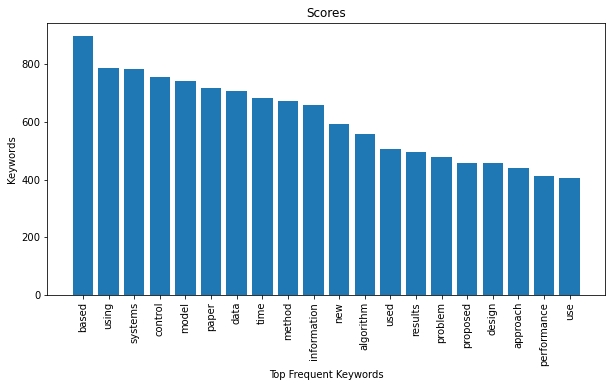

In [5]:
ws,ss = [],[]
topn = 20
for w,s in words_freq:
    if len(ws) == topn:
        break
    ws.append(w)
    ss.append(s)
bar_plot(ws,ss,'Top Frequent Keywords','Keywords','Scores')

#### Create List of Most Frequent Noun Phrases
Since, we cannot calculate the similarity scores of all words, we consider 5000 most frequent words. We consider only noun phrases from this list.

In [6]:
topn = 5000

keyword_freq = set()
for word,_ in words_freq[:topn]:
    # sanity check: making sure there is no duplicate word
    if word in keyword_freq:
        print('seen:',word)
    keyword_freq.add(word)
    
keyword_list = list(keyword_freq)

In [7]:
import en_core_web_sm

nlp = en_core_web_sm.load()
df['doc'] = df['Text'].apply(nlp)

noun_phrases_list = []
def get_pharses(x):
    for chunk in x.noun_chunks:
        noun_phrases_list.append(chunk.text.strip().lower())

df['doc'].apply(get_pharses)
noun_phrases = set(noun_phrases_list)

nouns = set()
def get_nouns(x):
    for token in x:
        if token.pos_ == "NOUN":
            nouns.add(token.text)

df['doc'].apply(get_nouns)

all_nouns = nouns.union(noun_phrases)

candidates = list(filter(lambda candidate: candidate in all_nouns, keyword_list))
len(candidates)

2961

#### Loading "distilroberta-base"

In [8]:
from transformers import AutoModel, AutoTokenizer
model_name = "distilroberta-base"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Getting Embeddings of Noun Phrases

In [9]:
candidate_tokens = tokenizer(candidates, padding=True, return_tensors="pt")
candidate_embeddings = model(**candidate_tokens)["pooler_output"]
candidate_embeddings = candidate_embeddings.detach().numpy()
candidate_embeddings.shape

(2961, 768)

#### Finding Top Semantically Similar Noun Phrases for Each Document
For each document and each word candidate, we calculate the cosine similarity score. Then we get the top_k words with highest scores and add the words and their scores to a dictionary for the document, docs_dict, and we add their scores to a dictionary that saves best scores for each word candidate, candidate_dict.

docs_dict can be used to get top k keywords for each documents

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

top_k = 5
docs = df['Text'].tolist()
candidate_dict = {x:[] for x in candidates}
docs_dict = {}

for doc in tqdm(docs):
    text_tokens = tokenizer(doc, padding=True, return_tensors="pt",max_length=512, truncation=True)
    text_embedding = model(**text_tokens)["pooler_output"]
    text_embedding = text_embedding.detach().numpy()
    distances = cosine_similarity(text_embedding, candidate_embeddings)
    doc_top_keywords = []
    for j in distances.argsort()[0][-top_k:]:
        candidate_dict[candidates[j]] += [distances[0][j]]
        doc_top_keywords.append((candidates[j],distances[0][j]))
    docs_dict[doc] = doc_top_keywords

 88%|████████▊ | 1758/2000 [06:43<01:01,  3.94it/s]

#### Finding top Most Occurring Semantically Similar Noun Phrases in Corpus
For each word candidate, we count number of documents the word is in their top semantically similar keywords. Then we select top_n words with most occupance as top keywords in Corpus. We order these keywords based on their average similarity scores and return as top keywords of the corpus.

In [ ]:
from statistics import mean
from collections import Counter

candidates_score = {}
len_count = Counter()

for _,v in candidate_dict.items():
    len_count[len(v)] += 1

len_count = {k:v for k,v in sorted(len_count.items(),reverse = True)}

top_n = 20
count_sum = 0
cut_off_len = 0
for k,v in len_count.items():
    if count_sum >= top_n:
        cut_off_len = k
        break
    count_sum += v

print('Least number of occurances as top 5 word in any document:',cut_off_len)
    
for k,v in candidate_dict.items():
    if cut_off_len <= len(v):
        candidates_score[k] = mean(v)

candidates_score = {k:v for k,v in sorted(candidates_score.items(),key = lambda x: x[1],reverse=True)}
candidates_score,len(candidates_score)

#### Plotting Top 20 Semantically Similar Words to Corpus and Their Scores
Since the scores are pretty close to 1 for these words, we adjust the scores to visualize their difference

In [ ]:
ws,ss = [],[]
topn = 20
for w,s in candidates_score.items():
    if len(ws) == topn:
        break
    ws.append(w)
    ss.append(s * 10000 - 9950)
bar_plot(ws,ss,'Top Keywords','Semantics Based Top Keywords','Adjusted Similarity Scores')